In [4]:
#import findspark
#findspark.init()
from pyspark import SparkContext
import pickle
from numpy import linalg as LA

sc = SparkContext(pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark.sql import *
sqlContext = SQLContext(sc)

from time import time
N=sc.defaultParallelism
print 'Number of executors=',N

Number of executors= 8


In [5]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [6]:
def index_to_letters(n):
    Letters=['B','S']
    out=''
    for i in range(8):
        out+=Letters[n%2]
        n=n/2
    return out
index_to_letters(201)

'SBBSBBSS'

In [13]:
import os
for index in range(256):
    
    file_index=index_to_letters(index)

    filename=data_dir+'/STAT_%s.pickle'%file_index
    if os.path.isfile(filename):
        continue
    print 'processing ',filename
    filebase='US_Weather_%s'%file_index
    !rm -rf $data_dir/$filebase*

    c_filename=filebase+'.csv.gz'
    u_filename=filebase+'.csv'

    command="curl https://mas-dse-open.s3.amazonaws.com/Weather/small/%s > %s/%s"%(c_filename,data_dir,c_filename)
    print command
    !$command
    !ls -lh $data_dir/$c_filename

    #unzip
    !gunzip -c $data_dir/$c_filename > $data_dir/$u_filename
    List=pickle.load(open(data_dir+'/'+u_filename,'rb'))
    len(List)

    df=sqlContext.createDataFrame(List)
    print df.count()

    measurements=['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS']

    sqlContext.registerDataFrameAsTable(df,'weather') #using older sqlContext instead of newer (V2.0) sparkSession

    from numpy import linalg as LA
    STAT={}  # dictionary storing the statistics for each measurement
    Clean_Tables={}

    for meas in measurements:
        t=time()
        Query="SELECT * FROM weather\n\tWHERE measurement = '%s'"%(meas)
        print Query
        df = sqlContext.sql(Query)
        data=df.rdd.map(lambda row: unpackArray(row['vector'],np.float16))
        #get very basic statistics
        print meas,data.count()
        if data.count() <50:
            continue
        STAT[meas]=computeOverAllDist(data)   # Compute the statistics 

        # compute covariance matrix
        OUT=computeCov(data)

        #find PCA decomposition
        eigval,eigvec=LA.eig(OUT['Cov'])

        # collect all of the statistics in STAT[meas]
        STAT[meas]['eigval']=eigval
        STAT[meas]['eigvec']=eigvec
        STAT[meas].update(OUT)

        print 'time for',meas,'is',time()-t

    filename=data_dir+'/STAT_%s.pickle'%file_index
    pickle.dump((STAT,STAT_Descriptions),open(filename,'wb'))

processing  ../../Data/Weather/STAT_BBBBSBBB.pickle
curl https://mas-dse-open.s3.amazonaws.com/Weather/small/US_Weather_BBBBSBBB.csv.gz > ../../Data/Weather/US_Weather_BBBBSBBB.csv.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4849k  100 4849k    0     0  2013k      0  0:00:02  0:00:02 --:--:-- 2013k
-rw-rw-r-- 1 ec2-user ec2-user 4.8M May  1 04:03 ../../Data/Weather/US_Weather_BBBBSBBB.csv.gz
12840
SELECT * FROM weather
	WHERE measurement = 'TMAX'
TMAX 3821
shape of E= (365,) shape of NE= (365,)
time for TMAX is 14.7317259312
SELECT * FROM weather
	WHERE measurement = 'SNOW'
SNOW 284
shape of E= (365,) shape of NE= (365,)
time for SNOW is 3.73427700996
SELECT * FROM weather
	WHERE measurement = 'SNWD'
SNWD 249
shape of E= (365,) shape of NE= (365,)
time for SNWD is 3.3807990551
SELECT * FROM weather
	WHERE measurement = 'TMIN'
TMIN 3797
shape of E= (365,) shape of NE=

In [19]:
index

208

In [22]:
filename

'../../Data/Weather/STAT_SSSSSSSS.pickle'

In [24]:
import os
os.path.isfile(filename)

True

In [2]:
%cd /dev/shm/256_STAT_unzipped
!ls | wc

/dev/shm/256_STAT_unzipped
    256     256    5376


In [3]:
from pickle import load,dump

In [ ]:
filename='STAT_BBBBBBSS.pickle'
STAT=load(open(filename,'r'))

In [10]:
STAT[0].keys()

['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']

In [24]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['load', 'eigvals']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [13]:
from pickle import load,dump
import numpy as np
from glob import glob
Eigvals={}
%cd /dev/shm/256_STAT_unzipped/
for filename in glob('STAT_*.pickle'):
    print filename
    id=filename[5:13]
    STAT=load(open(filename,'r'))
    for meas in STAT[0].keys():
        D={}
        eigvals=STAT[0][meas]['eigval']
        eigvals/=sum(eigvals)
        D['Eigvals']=np.cumsum(eigvals)[:20]
        D['counts']=min(STAT[0][meas]['NE'])
        Eigvals[id+'_'+meas]=D

!rm eigvals.pickle
dump(Eigvals,open('eigvals.pickle','w'))
!ls -l eigvals.pickle
 

/dev/shm/256_STAT_unzipped
STAT_BSSSSSBB.pickle
STAT_BSSSSBSS.pickle
STAT_BSSSSBSB.pickle
STAT_BSSSSBBS.pickle
STAT_BSSSSBBB.pickle
STAT_BSSSBSSS.pickle
STAT_BSSSBSSB.pickle
STAT_BSSSBSBS.pickle
STAT_BSSSBSBB.pickle
STAT_BSSSBBSS.pickle
STAT_BSSSBBSB.pickle
STAT_BSSSBBBS.pickle
STAT_BSSSBBBB.pickle
STAT_BSSBSSSS.pickle
STAT_BSSBSSSB.pickle
STAT_BSSBSSBS.pickle
STAT_BSSBSSBB.pickle
STAT_BSSBSBSS.pickle
STAT_BSSBSBSB.pickle
STAT_BSSBSBBS.pickle
STAT_BSSBSBBB.pickle
STAT_BSSBBSSS.pickle
STAT_BSSBBSSB.pickle
STAT_BSSBBSBS.pickle
STAT_BSSBBSBB.pickle
STAT_BSSBBBSS.pickle
STAT_BSSBBBSB.pickle
STAT_BSSBBBBS.pickle
STAT_BSSBBBBB.pickle
STAT_BSBSSSSS.pickle
STAT_BSBSSSSB.pickle
STAT_BSBSSSBS.pickle
STAT_BSBSSSBB.pickle
STAT_BSBSSBSS.pickle
STAT_BSBSSBSB.pickle
STAT_BSBSSBBS.pickle
STAT_BSBSSBBB.pickle
STAT_BSBSBSSS.pickle
STAT_BSBSBSSB.pickle
STAT_BSBSBSBS.pickle
STAT_BSBSBSBB.pickle
STAT_BSBSBBSS.pickle
STAT_BSBSBBSB.pickle
STAT_BSBSBBBS.pickle
STAT_BSBSBBBB.pickle
STAT_BSBBSSSS.pickle
STAT_BS

ValueError: insecure string pickle

In [15]:
len(Eigvals.keys())

1178

In [16]:
!rm eigvals.pickle
dump(Eigvals,open('eigvals.pickle','w'))

In [ ]:
%cd /dev/shm/256_STAT_unzipped/
!ls -lh eigvals.pickle
!gzip eigvals.pickle

In [6]:
!ls -lh eigvals.pickle*
!cp eigvals.pickle.gz /home/ec2-user/workspace/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/2.PCA/

-rw-rw-r-- 1 ec2-user ec2-user 304K May  2 19:28 eigvals.pickle.gz


In [10]:
import pickle
with open('eigvals.pickle','rb') as file:
    Eigvals=pickle.load(file)
len(Eigvals)

6

In [ ]:
import pandas as pd
_index=[]
_eigs=[]
_meas=[]
_count=[]
k=5
for key in Eigvals.keys():
    index,meas=key[:8],key[9:]
    _index.append(index)
    _meas.append(meas)
    D=Eigvals[key]
    _eigs.append(D['Eigvals'][:k])
    _count.append(D['counts'])
    #print index,meas,count,eigs

df_eigvals=pd.DataFrame({'index':_index,
             'meas':_meas,
             'count':_count,
             'eigs':_eigs})

In [ ]:
%pylab inline

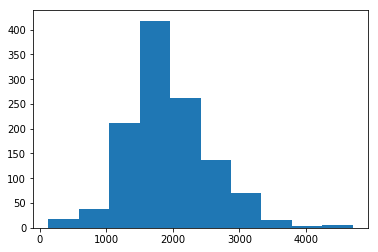

In [50]:
C=[e for e in df_eigvals['count']]
hist(C);

In [69]:
df_L=df_eigvals[df_eigvals['count']>1500]
print df_eigvals.shape, df_L.shape

(1178, 4) (913, 4)


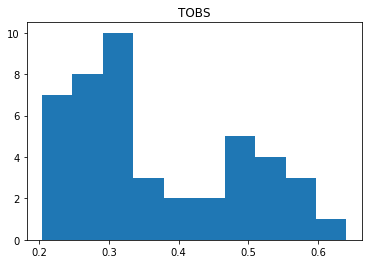

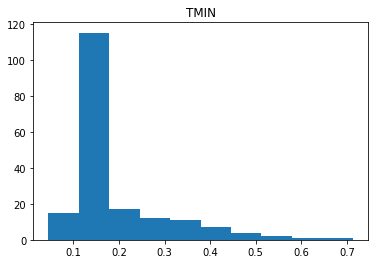

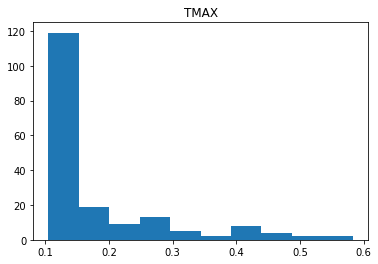

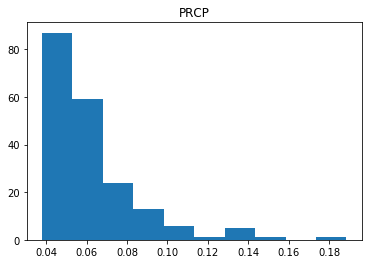

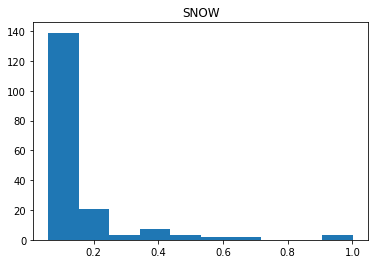

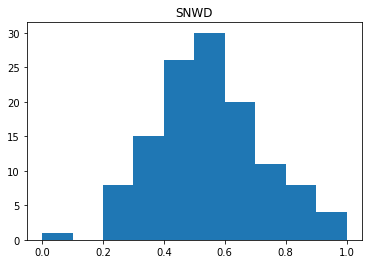

In [70]:
for meas in ['TOBS','TMIN','TMAX','PRCP','SNOW','SNWD']:
    H=[e[2] for e in df_L[df_L['meas']==meas]['eigs']]
    figure();
    hist(H);
    title(meas)

In [72]:
df_L=df_L.assign(good = lambda df:False)
df_L.head()

,count,eigs,index,meas,good
0,2540.0,"[0.190705397229, 0.23512853515, 0.274170953267...",SBSBSBSS,TMIN,False
1,2548.0,"[0.0782788995524, 0.10590714767, 0.13086872690...",SSSBSBBB,PRCP,False
3,1727.0,"[0.689664535368, 0.702845732753, 0.71270013178...",SSSSBBSS,TMIN,False
4,1548.0,"[0.0423725203978, 0.0809388670768, 0.115980280...",BBSSSSBS,TMAX,False
5,2166.0,"[0.054003540836, 0.0927252596993, 0.1283880382...",SSBBBSBS,SNOW,False


In [90]:
#df1 = df1.assign(e=p.Series(np.random.randn(sLength)).values)
def find_good(row):
    print 'in find_good:',row
    if row['meas']=='TOBS': # and row['eigs'][2]>0.45:
        return True
    return False
df_L['good']=df_L.apply(find_good)
df_L.head(20)
#df_L.assign(good = lambda df:(df['meas']=='TOBS')*(df['eigs'][2]>0.45))
#df_L.head(20)

in find_good: 0       2540
1       2548
3       1727
4       1548
5       2166
8       1624
9       2387
11      1934
12      1598
13      1735
16      2585
17      2466
18      2140
19      2100
20      1525
21      2230
22      1838
23      2528
24      2257
25      2850
26      1984
27      2718
28      2819
29      1649
30      2008
31      2268
32      3070
34      3179
35      1755
38      1996
        ... 
1139    1586
1142    2143
1143    1823
1144    4705
1145    1621
1146    1643
1147    1503
1148    1516
1149    2057
1150    2482
1151    1986
1152    1555
1153    1858
1154    2374
1155    3263
1156    2555
1157    1652
1159    1595
1160    3107
1161    1563
1162    3585
1164    2510
1166    2475
1167    1531
1168    1857
1169    1930
1171    2396
1174    1889
1175    3848
1176    1793
Name: count, dtype: object
in find_good: 0       2540.0
1       2548.0
3       1727.0
4       1548.0
5       2166.0
8       1624.0
9       2387.0
11      1934.0
12      1598.0
13      1735.0
16

KeyError: ('meas', u'occurred at index count')

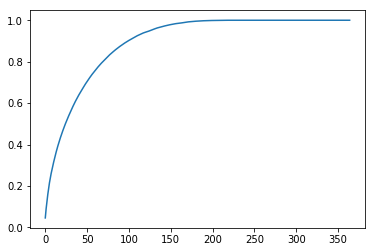

In [27]:
eigvals=STAT[0]['SNOW']['eigval']
eigvals/=sum(eigvals)
plot(np.cumsum(eigvals))

In [1]:
%pwd

u'/home/ec2-user/workspace/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/2.PCA'